In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d as mv_avg
from scipy import stats

from aux import Generic
from disp import set_font_size
from ntwk import LIFNtwkI, join_w

cc = np.concatenate

C_M = .2e-9  # F
G_L = 10e-9  # S
T_M = C_M/G_L  # s
E_L = -0.05  # V
V_TH = -0.04  # V
V_R = -0.05  # V
T_R = 0.001  # s

DT = 0.0005

Plot output spike probability from $k_{in}$ input spikes w/in one timescale ($\tau_m$) as func of synaptic weight.

In [2]:
n_trials = 50
k_in = [0, 1, 5, 10]  # total number of input spikes
w = np.linspace(0, .5e-8, 100)  # excitatory weights

p_spks = {k_in_: [] for k_in_ in k_in}
t = DT * np.arange(int(np.round(T_M/DT)), dtype=float)
clamp = Generic(v={0: np.array([E_L])}, spk={})
i_ext = np.zeros(len(t))

for k_in_ in k_in:
    p_spk = []
    for w_ in w:
        ntwk = LIFNtwkI(
            c_m=C_M,
            g_l=G_L,
            e_l=E_L,
            v_th=V_TH,
            v_r=V_R,
            t_r=T_R,
            w_r=np.zeros((1, 1)),
            w_u=w_*np.eye(1),
            sparse=False)
        
        spk_out_ctr = 0
        
        for tr_ctr in range(n_trials):
            # make stim
            spks_u = np.zeros((len(t), 1))
            for spk_ctr in range(k_in_):
                spks_u[np.random.randint(0, k_in_), 0] += 1
                
            # drive ntwk
            rslt = ntwk.run(dt=DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
            
            # count output spks
            spk_out_ctr += int(rslt.spks[:, 0].sum() > 0)
            
        p_spk.append(spk_out_ctr/n_trials)
    p_spks[k_in_] = copy(p_spk)

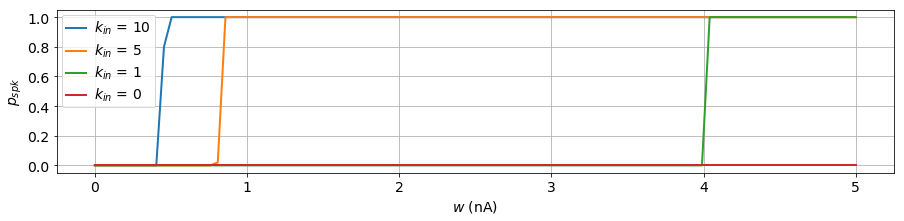

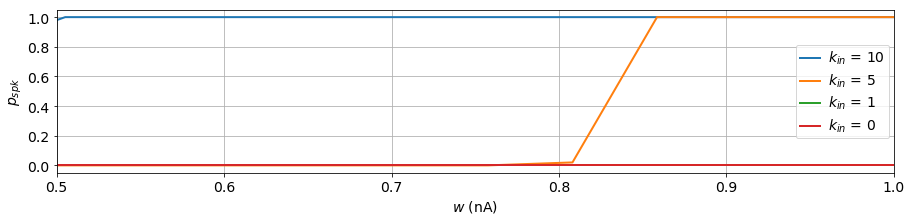

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for k_in_ in k_in[::-1]:
    ax.plot(1e9 * w, p_spks[k_in_], lw=2)
    
ax.set_xlabel(r'$w$ (nA)')
ax.set_ylabel(r'$p_{spk}$')
ax.legend([r'$k_{in}$ = ' + '{}'.format(k_in_) for k_in_ in k_in[::-1]])

ax.grid()
set_font_size(ax, 14)

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
for k_in_ in k_in[::-1]:
    ax.plot(1e9 * w, p_spks[k_in_], lw=2)

ax.set_xlim(.5, 1)
ax.set_xlabel(r'$w$ (nA)')
ax.set_ylabel(r'$p_{spk}$')
ax.legend([r'$k_{in}$ = ' + '{}'.format(k_in_) for k_in_ in k_in[::-1]])

ax.grid()
set_font_size(ax, 14)

Using reduced model math, calc about how many cells in a 200-cell ensemble need to spike w/in $\tau_m$ to activate the whole ensemble.

In [4]:
bi_svl = stats.binom.sf

def calc_n(tht_w, n_s, q):
    return n_s / bi_svl(tht_w-.01, n_s, q)  # th_w offset to get greater-than-or-equal-to survival func

print(calc_n(tht_w=5, n_s=28, q=.1))

197.02782857977724


Test approximation of LIF ensemble activation given reduced model math.

In [5]:
# build ensemble
n_e = 200
q = .1
w_ee = .85e-9

n_spk_0 = np.arange(27, 30)
n_trial = 5

t = np.arange(0, 2*T_M, DT)
n_t = len(t)
noise = .1e-9

# run smlns
np.random.seed(0)
ppln_frs = []

for n_spk_0_ in n_spk_0:  # loop over init spk counts
    ppln_fr = np.nan * np.zeros((n_trial, n_t))
    
    for tr_ctr in range(n_trial):
        # build weights
        cxn = np.random.rand(n_e, n_e) < q
        w_r = w_ee * cxn.astype(float)
        
        # build ntwk
        ntwk = LIFNtwkI(
            c_m=C_M,
            g_l=G_L,
            e_l=E_L,
            v_th=V_TH,
            v_r=V_R,
            t_r=T_R,
            w_r=w_r,
            w_u=None)
        
        # impose initial spikes
        n_t_0 = int(round(T_M/DT))
        spks_0 = cc([np.ones(n_spk_0_), np.zeros(n_t_0*n_e - n_spk_0_)])
        np.random.shuffle(spks_0)
        spks_0 = spks_0.reshape((n_t_0, n_e))
        spk_clamp = {DT*t_idx: spks_0[t_idx] for t_idx in range(len(spks_0))}
        
        clamp = Generic(v={0: np.repeat(E_L, n_e)}, spk=spk_clamp)
        
        # run ntwk
        rslt = ntwk.run(dt=DT, clamp=clamp, i_ext=np.random.normal(0, noise, (n_t, n_e)))
        
        # store ppln firing rate
        ppln_fr[tr_ctr] = mv_avg(rslt.spks.mean(1)/DT, int(round(.002/DT)))
        
    ppln_frs.append(ppln_fr)

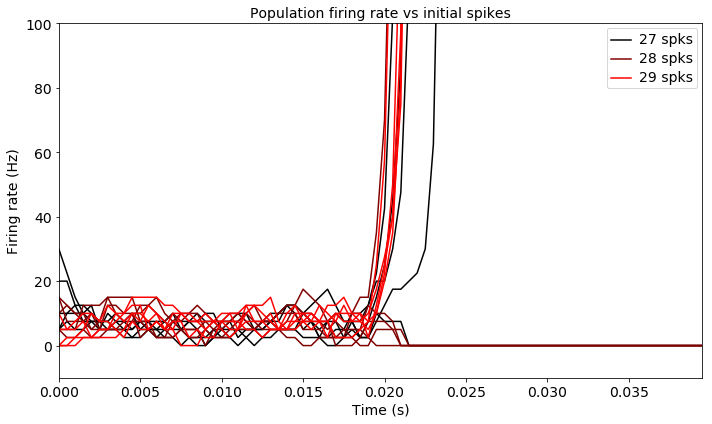

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), tight_layout=True)
clrs = np.transpose([np.linspace(0, 1, len(n_spk_0)), np.zeros(len(n_spk_0)), np.zeros(len(n_spk_0))])
hs = []

for n_spk_0_, ppln_fr, clr in zip(n_spk_0, ppln_frs, clrs):
    hs.append(ax.plot(t, ppln_fr.T, c=clr, label='{} spks'.format(n_spk_0_))[0])

ax.set_xlim(t[0], t[-1])
ax.set_ylim(-10, 100)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Firing rate (Hz)')
ax.legend(handles=hs)
ax.set_title('Population firing rate vs initial spikes')

set_font_size(ax, 14)

Connect 10 excitatory ensembles in sequence.

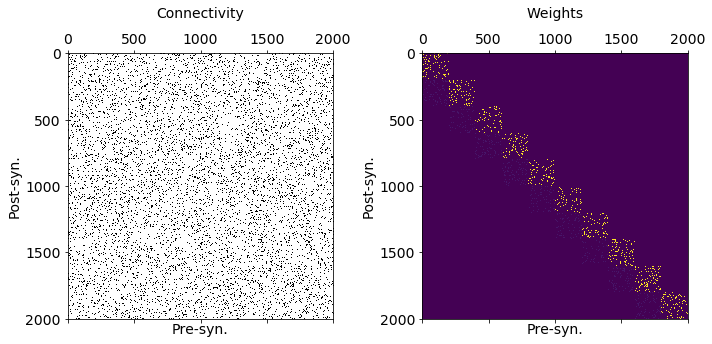

In [7]:
seed = 0
np.random.seed(seed)

n_m = 10
m_e = 200
n_e = n_m * m_e

q = .1
w_n_ee = 0  # baseline
w_m_ee = .85e-9  # w/in ensembles
w_mm_ee = 0.05e-9  # btwn subsequent ensembles

# make baseline connectivity matrix
cxn = np.random.rand(n_e, n_e) < q
w_r = w_n_ee * cxn.astype(float)

# embed ensembles
for ctr in range(n_m):
    mask_m = np.zeros(cxn.shape, dtype=bool)
    mask_m[m_e*ctr:m_e*(ctr+1), m_e*ctr:m_e*(ctr+1)] = True
    w_r[cxn & mask_m] = w_m_ee
    
# embed feed-forward cxns between ensembles
for ctr in range(n_m-1):
    mask_mm = np.zeros(cxn.shape, dtype=bool)
    mask_mm[m_e*(ctr+1):m_e*(ctr+2), m_e*ctr:m_e*(ctr+1)] = True
    w_r[cxn & mask_mm] = w_mm_ee

# build ntwk
ntwk = LIFNtwkI(
    c_m=C_M,
    g_l=G_L,
    e_l=E_L,
    v_th=V_TH,
    v_r=V_R,
    t_r=T_R,
    w_r=w_r,
    w_u=None)

# plot cxn sparsity and weight matrix
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('Connectivity\n')
axs[1].matshow(w_r)
axs[1].set_title('Weights\n')

for ax in axs:
    ax.set_xlabel('Pre-syn.')
    ax.set_ylabel('Post-syn.')
    set_font_size(ax, 14)

Activate first ensemble to see if rest of ensembles activate subsequently.

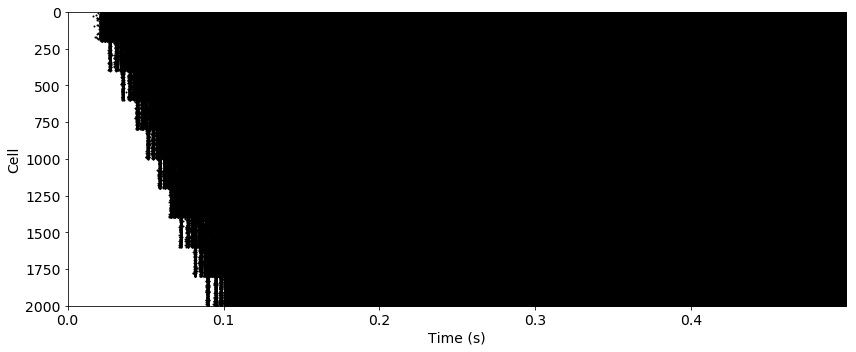

In [8]:
t = np.arange(0, .5, DT)
n_t = len(t)
n_t_m = int(round(T_M/DT))

noise = .4e-9

# stim
np.random.seed(seed)
i_ext = np.zeros((n_t, n_e))
i_ext[:n_t_m, :m_e] = noise*np.random.randn(n_t_m, m_e)

# run ntwk
clamp = Generic(v={0: np.repeat(E_L, n_e)}, spk={})
rslt = ntwk.run(dt=DT, clamp=clamp, i_ext=i_ext)

# plot raster
fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)
ax.scatter(rslt.spks_t, rslt.spks_c, s=1, c='k')
ax.set_xlim(t[0], t[-1])
ax.set_ylim(n_e, -1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Cell')

set_font_size(ax, 14)